In [1]:
from imblearn.under_sampling import NearMiss, ClusterCentroids, RandomUnderSampler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Prepare Data

In [2]:
df = pd.read_csv("../data/processed/transformed_data.csv", index_col=0)
df = df.sort_index(axis=1)
df.head(3)

,3D_secured,CARD_Diners,CARD_Master,CARD_Visa,Day of Month,Day of Week,PSP_Goldcard,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,Time of Day,amount,previous_attemps,success
0,0,0,0,1,1,5,0,0,0,1,0,89,0,0
1,0,0,0,1,1,5,0,0,0,1,0,89,1,1
2,1,1,0,0,1,5,0,0,0,1,0,238,0,0


In [3]:
# Auswahl Features und Zielvariable
zielvariable = "success"
features = df.columns.drop(zielvariable)
print(features)
X = df[features]
y = df[zielvariable]

# # Aufteilung der Daten in Trainings- und Testdatensätze
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

Index(['3D_secured', 'CARD_Diners', 'CARD_Master', 'CARD_Visa', 'Day of Month',
       'Day of Week', 'PSP_Goldcard', 'PSP_Moneycard', 'PSP_Simplecard',
       'PSP_UK_Card', 'Time of Day', 'amount', 'previous_attemps'],
      dtype='object')


# Baseline model

In [4]:
rf_classifier_baseline = RandomForestClassifier(
    n_estimators=500,
    max_features=10,
    max_depth=8,
    random_state=42,
)
rf_classifier_baseline.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=10, n_estimators=500,
                       random_state=42)

In [5]:
# Vorhersagen auf dem Testdatensatz
y_pred = rf_classifier_baseline.predict(X_test)

# Bewertung des Modells
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1, average="weighted")
recall = recall_score(y_test, y_pred, pos_label=1, average="weighted")
f1 = f1_score(y_test, y_pred, pos_label=1, average="weighted")

print(f"Baseline Model Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")


unique_label = np.unique([y_test, y_pred])
cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=unique_label),
    index=["true:{:}".format(x) for x in unique_label],
    columns=["pred:{:}".format(x) for x in unique_label],
)
print(cmtx)

# Perform cross-validation on the training set using precision as the scoring metric
cv_scores = cross_val_score(
    rf_classifier_baseline, X_test, y_test, cv=5, scoring="f1_weighted"
)

# Print out the cross-validation scores
print("Baseline model cross-validation scores: ", cv_scores)
print("Baseline model mean cross-validation score: ", np.mean(cv_scores))

Baseline Model Metrics:
Accuracy: 0.81
Precision: 0.78
Recall: 0.81
F1: 0.73
        pred:0  pred:1
true:0    8111      60
true:1    1917     111
Baseline model cross-validation scores:  [0.7277403  0.73363266 0.73118051 0.73983332 0.73237477]
Baseline model mean cross-validation score:  0.7329523124686068


Get random data to test predicting values function

In [6]:
# Get some original Data to test
original_data = pd.read_excel("../data/raw/PSP_Jan_Feb_2019.xlsx", index_col=0)
testdata = original_data.sample(5, random_state=42)
# Add previous_attemps & delete PSP
testdata["previous_attemps"] = np.random.randint(low=0, high=4, size=(len(testdata),))
testdata.drop("PSP", axis=1, inplace=True)
testdata.drop("success", axis=1, inplace=True)
testdata.head()

,tmsp,country,amount,3D_secured,card,previous_attemps
5087,2019-01-05 14:06:04,Austria,215,0,Master,1
22530,2019-01-27 04:44:57,Germany,240,0,Diners,1
15518,2019-01-17 20:30:02,Switzerland,382,1,Master,3
3418,2019-01-03 21:01:04,Germany,32,1,Master,1
36168,2019-02-11 08:20:46,Austria,211,0,Master,3


Build function to predict PSP

In [7]:
def transform_data(input_df: pd.DataFrame):
    """
    :param input_df: DataFrame with values for "tmsp", "country", "amount", "success", "3D_secured", "previous_attemps" and "card"
    """
    input_df["Day of Month"] = input_df["tmsp"].dt.day  # Extract day from timestamp
    input_df["Day of Week"] = input_df[
        "tmsp"
    ].dt.dayofweek  # Extract day of the week from timestamp
    input_df["Time of Day"] = input_df["tmsp"].dt.hour  # Extract hour from timestamp
    input_df.drop("tmsp", axis=1, inplace=True)
    input_df.drop("country", axis=1, inplace=True)

    # One-Hot-Encode Card
    list_card = ["Diners", "Master", "Visa"]
    for card in list_card:
        input_df["CARD_" + card] = 0
    for index, row in input_df.iterrows():
        input_df.loc[index, "CARD_" + row["card"]] = 1
    input_df.drop("card", axis=1, inplace=True)
    input_df = input_df.sort_index(axis=1)
    return input_df


def find_best_psp(x: pd.Series, possible_psps: pd.DataFrame):
    series = x.copy()
    series.index = series.index.str[15:]
    df = series.to_frame(name="success_probability")
    df["cost"] = df.apply(lambda x: possible_psps.loc[x.name, "Cost_success"], axis=1)
    weight_on_success = 0.75
    weight_on_costs = 0.25
    df["weighted_score"] = df.apply(
        lambda x: weight_on_success * x["success_probability"]
        + weight_on_costs * (1 / x["cost"]),
        axis=1,
    )
    # print(f"Following Dataframe should take {df["weighted_score"].idxmax()} as the PSP")
    # print(df.head())
    return df["weighted_score"].idxmax()


def predict_psp_baseline(input_df: pd.DataFrame):
    """
    :param input_df: DataFrame with values for "tmsp", "country", "amount", "success", "3D_secured", "previous_attemps" and "card"
    """
    # Feature engineering
    input_df = transform_data(input_df)

    # Possible PSP with costs
    possible_psps = pd.DataFrame(
        {
            "PSP": ["Goldcard", "Moneycard", "Simplecard", "UK_Card"],
            "Cost_success": [10, 5, 1.0, 3],
            "Cost_failure": [5, 2, 0.5, 1],
        }
    ).set_index("PSP")
    # Init PSP prediction columns
    prediction_column = "PSP_PREDICTION_"
    psp_prediction_columns = []
    for psp in possible_psps.index:
        input_df["PSP_" + psp] = 0
        psp_prediction_columns.append("PSP_PREDICTION_" + psp)
    input_df = input_df.sort_index(axis=1)
    input_with_prediction = input_df.copy()

    # Find PSP with highest
    for index, psp in possible_psps.iterrows():
        # Test out using this PSP
        datapoints_copy = input_df.copy()
        datapoints_copy["PSP_" + index] = 1
        input_with_prediction[prediction_column + index] = (
            rf_classifier_baseline.predict_proba(datapoints_copy)[:, 1]
        )

    # Find max probability

    input_with_prediction["Best PSP"] = input_with_prediction[
        psp_prediction_columns
    ].idxmax(axis=1)
    input_with_prediction["Best Probability"] = input_with_prediction.apply(
        lambda x: x[x["Best PSP"]], axis=1
    )
    input_with_prediction["Best PSP"] = input_with_prediction["Best PSP"].str[15:]
    # print(input_with_prediction.head())
    # Taking costs into account
    input_with_prediction["Recommendation"] = input_with_prediction[
        psp_prediction_columns
    ].apply(lambda x: find_best_psp(x, possible_psps), axis=1)
    input_with_prediction.drop(psp_prediction_columns, axis=1, inplace=True)

    return input_with_prediction[["Best PSP", "Best Probability", "Recommendation"]]

Test prediction

In [8]:
predict_psp_baseline(testdata.sample(5)).head()

,Best PSP,Best Probability,Recommendation
15518,Goldcard,0.541183,Goldcard
22530,Goldcard,0.265807,Simplecard
3418,Moneycard,0.317841,Simplecard
36168,Goldcard,0.405290,Goldcard
5087,Goldcard,0.367369,Simplecard


# Optimized Model

## Optimizing Random Forest

In [ ]:
# Initialisierung und Training des Random Forest Classifiers
rf_classifier = RandomForestClassifier(random_state=42)

param_grid = {
    "n_estimators": [30, 100, 300, 1000],
    "max_features": ["sqrt", "log2", 10, None],
    "max_depth": [3, 6, 8, 10],
    "criterion": ["gini", "entropy"],
}

CV_rfc = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    cv=3,
    verbose=3,
    n_jobs=-1,
    scoring="f1_weighted",
)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

Fitting 3 folds for each of 128 candidates, totalling 384 fits
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'n_estimators': 100}


In [38]:
# Get the best estimator
best_random_forest = RandomForestClassifier(
    verbose=3, random_state=42, n_estimators=100, max_depth=10, max_features=None
)
best_random_forest.fit(X_train, y_train)
# Predict the target on the test data
predictions = best_random_forest.predict(X_test)
# Print Precision
print("Test F1-Score: ", f1_score(y_test, predictions, average="weighted"))

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    1.6s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s


## Optimizing Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialisierung und Training des Neural Net
gboosting = GradientBoostingClassifier(verbose=3, random_state=42)
param_grid = {
    "n_estimators": [50, 100, 300, 500, 1000],
    "learning_rate": [0.01, 0.1, 1],
    "max_depth": [3, 7, 10],
}


CV_rfc = GridSearchCV(
    estimator=gboosting,
    param_grid=param_grid,
    cv=3,
    verbose=3,
    n_jobs=-1,
    scoring="f1_weighted",
)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
      Iter       Train Loss   Remaining Time 
         1           0.9902           29.48s
         2           0.9765           28.21s
         3           0.9654           28.82s
         4           0.9564           28.40s
         5           0.9489           28.55s
         6           0.9425           28.18s
         7           0.9372           27.93s
         8           0.9325           28.02s
         9           0.9286           28.10s
        10           0.9251           28.16s
        11           0.9219           28.03s
        12           0.9192           28.02s
        13           0.9165           27.88s
        14           0.9139           27.78s
        15           0.9116           27.60s
        16           0.9096           27.57s
        17           0.9075           27.55s
        18           0.9052           27.46s
        19           0.9035           27.31s
        20           0.9012          

In [37]:
# Get the best estimator
clf_best = GradientBoostingClassifier(
    verbose=3, random_state=42, n_estimators=500, max_depth=7, learning_rate=0.1
)
clf_best.fit(X_train, y_train)
# Predict the target on the test data
predictions = clf_best.predict(X_test)
# Print Precision
print("Test F1-Score: ", f1_score(y_test, predictions, average="weighted"))

      Iter       Train Loss   Remaining Time 
         1           0.9902           46.41s
         2           0.9765           40.43s
         3           0.9654           37.37s
         4           0.9564           36.28s
         5           0.9489           34.97s
         6           0.9425           33.56s
         7           0.9372           33.04s
         8           0.9325           32.68s
         9           0.9286           32.67s
        10           0.9251           33.08s
        11           0.9219           32.90s
        12           0.9192           32.51s
        13           0.9165           32.08s
        14           0.9139           32.98s
        15           0.9116           34.10s
        16           0.9096           35.09s
        17           0.9075           35.85s
        18           0.9052           36.20s
        19           0.9035           36.13s
        20           0.9012           35.74s
        21           0.8998           35.63s
        2

In [36]:
clf_best

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 100), max_iter=500,
              random_state=42, verbose=True)

# Calculate Costs and predict new values

## Testing different Classifiers

In [22]:
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


def objective(params):
    classifier_type = params["type"]
    del params["type"]
    if classifier_type == "svm":
        clf = SVC(**params)
    elif classifier_type == "randomforest":
        clf = RandomForestClassifier(**params)
    elif classifier_type == "gradientboost":
        clf = GradientBoostingClassifier(**params)
    elif classifier_type == "logreg":
        clf = LogisticRegression(**params)
    elif classifier_type == "neuralnet":
        clf = MLPClassifier(**params)
    else:
        return 0
    f1_weighted = cross_val_score(
        clf, X, y, cv=5, scoring="f1_weighted", n_jobs=-1
    ).mean()

    # Because fmin() tries to minimize the objective, this function must return the negative accuracy.
    return {"loss": -f1_weighted, "status": STATUS_OK}


search_space = hp.choice(
    "classifier_type",
    [
        {
            "type": "svm",
            "C": hp.lognormal("SVM_C", 0, 1.0),
            "kernel": hp.choice("kernel", ["linear", "rbf"]),
        },
        {
            "type": "randomforest",
            "n_estimators": hp.uniformint("random_n_estimators", 50, 1000),
            "max_depth": hp.uniformint("random_max_depth", 2, 10),
            "criterion": hp.choice("criterion", ["gini", "entropy"]),
        },
        {
            "type": "gradientboost",
            "n_estimators": hp.uniformint("gradient_n_estimators", 50, 1000),
            "max_depth": hp.uniformint("gradient_max_depth", 2, 10),
            "learning_rate": hp.uniform("learning_rate", 0.1, 5),
            "subsample": hp.uniform("subsample", 0.1, 1.0),
        },
        {
            "type": "logreg",
            "C": hp.lognormal("LR_C", 0, 1.0),
            "solver": hp.choice("solver", ["liblinear", "lbfgs"]),
        },
        {
            "type": "neuralnet",
            "hidden_layer_sizes": hp.choice(
                "hidden_layer_sizes",
                [(100,), (100, 100), (100, 50, 100), (100, 50, 25, 50, 100)],
            ),
            "activation": hp.choice(
                "activation", ["identity", "logistic", "tanh", "relu"]
            ),
        },
    ],
)
trials = Trials()
algo = tpe.suggest  # Tree of Parzen Estimators
best_result = fmin(
    fn=objective, space=search_space, algo=algo, max_evals=500, trials=trials
)

print(space_eval(search_space, best_result))

  0%|          | 0/500 [00:00<?, ?trial/s, best loss=?]

 61%|██████▏   | 307/500 [19:01:15<11:57:28, 223.05s/trial, best loss: -0.7333144696230892]  


KeyboardInterrupt: 

In [28]:
trials.best_trial

{'state': 2,
 'tid': 242,
 'spec': None,
 'result': {'loss': -0.7333144696230892, 'status': 'ok'},
 'misc': {'tid': 242,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'LR_C': [],
   'SVM_C': [],
   'activation': [242],
   'classifier_type': [242],
   'criterion': [],
   'gradient_max_depth': [],
   'gradient_n_estimators': [],
   'hidden_layer_sizes': [242],
   'kernel': [],
   'learning_rate': [],
   'random_max_depth': [],
   'random_n_estimators': [],
   'solver': [],
   'subsample': []},
  'vals': {'LR_C': [],
   'SVM_C': [],
   'activation': [np.int64(2)],
   'classifier_type': [np.int64(4)],
   'criterion': [],
   'gradient_max_depth': [],
   'gradient_n_estimators': [],
   'hidden_layer_sizes': [np.int64(2)],
   'kernel': [],
   'learning_rate': [],
   'random_max_depth': [],
   'random_n_estimators': [],
   'solver': [],
   'subsample': []}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2024, 12, 23, 4, 23, 

Neural Net was the best.
Now trying out what performance can be achieved.

In [32]:
# Initialisierung und Training des Neural Net
clf = MLPClassifier(random_state=42, verbose=True, max_iter=500)

param_grid = {
    "hidden_layer_sizes": [(100,), (100, 100), (100, 50, 100), (100, 50, 25, 50, 100)],
    "activation": ["identity", "logistic", "tanh", "relu"],
    "learning_rate": ["constant", "invscaling", "adaptive"],
}


CV_rfc = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=3,
    verbose=3,
    n_jobs=-1,
    scoring="f1_weighted",
)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Iteration 1, loss = 0.50495431
Iteration 2, loss = 0.50335616
Iteration 3, loss = 0.50182613
Iteration 4, loss = 0.50057827
Iteration 5, loss = 0.49817145
Iteration 6, loss = 0.49577774
Iteration 7, loss = 0.49354350
Iteration 8, loss = 0.49159996
Iteration 9, loss = 0.49138260
Iteration 10, loss = 0.49081048
Iteration 11, loss = 0.49189025
Iteration 12, loss = 0.49094353
Iteration 13, loss = 0.49101285
Iteration 14, loss = 0.49019816
Iteration 15, loss = 0.48972166
Iteration 16, loss = 0.48931743
Iteration 17, loss = 0.48930077
Iteration 18, loss = 0.48865892
Iteration 19, loss = 0.48807047
Iteration 20, loss = 0.48716022
Iteration 21, loss = 0.48629797
Iteration 22, loss = 0.48591555
Iteration 23, loss = 0.48692030
Iteration 24, loss = 0.48609218
Iteration 25, loss = 0.48509262
Iteration 26, loss = 0.48471827
Iteration 27, loss = 0.48499878
Iteration 28, loss = 0.48292052
Iteration 29, loss = 0.48299832
Iteration 30, loss 

In [33]:
# Get the best estimator
clf_best = CV_rfc.best_estimator_
# Predict the target on the test data
predictions = clf_best.predict(X_test)
# Print Precision
print("Test F1-Score: ", f1_score(y_test, predictions, average="weighted"))

Test F1-Score:  0.7413390140785745


# Check Feature importance

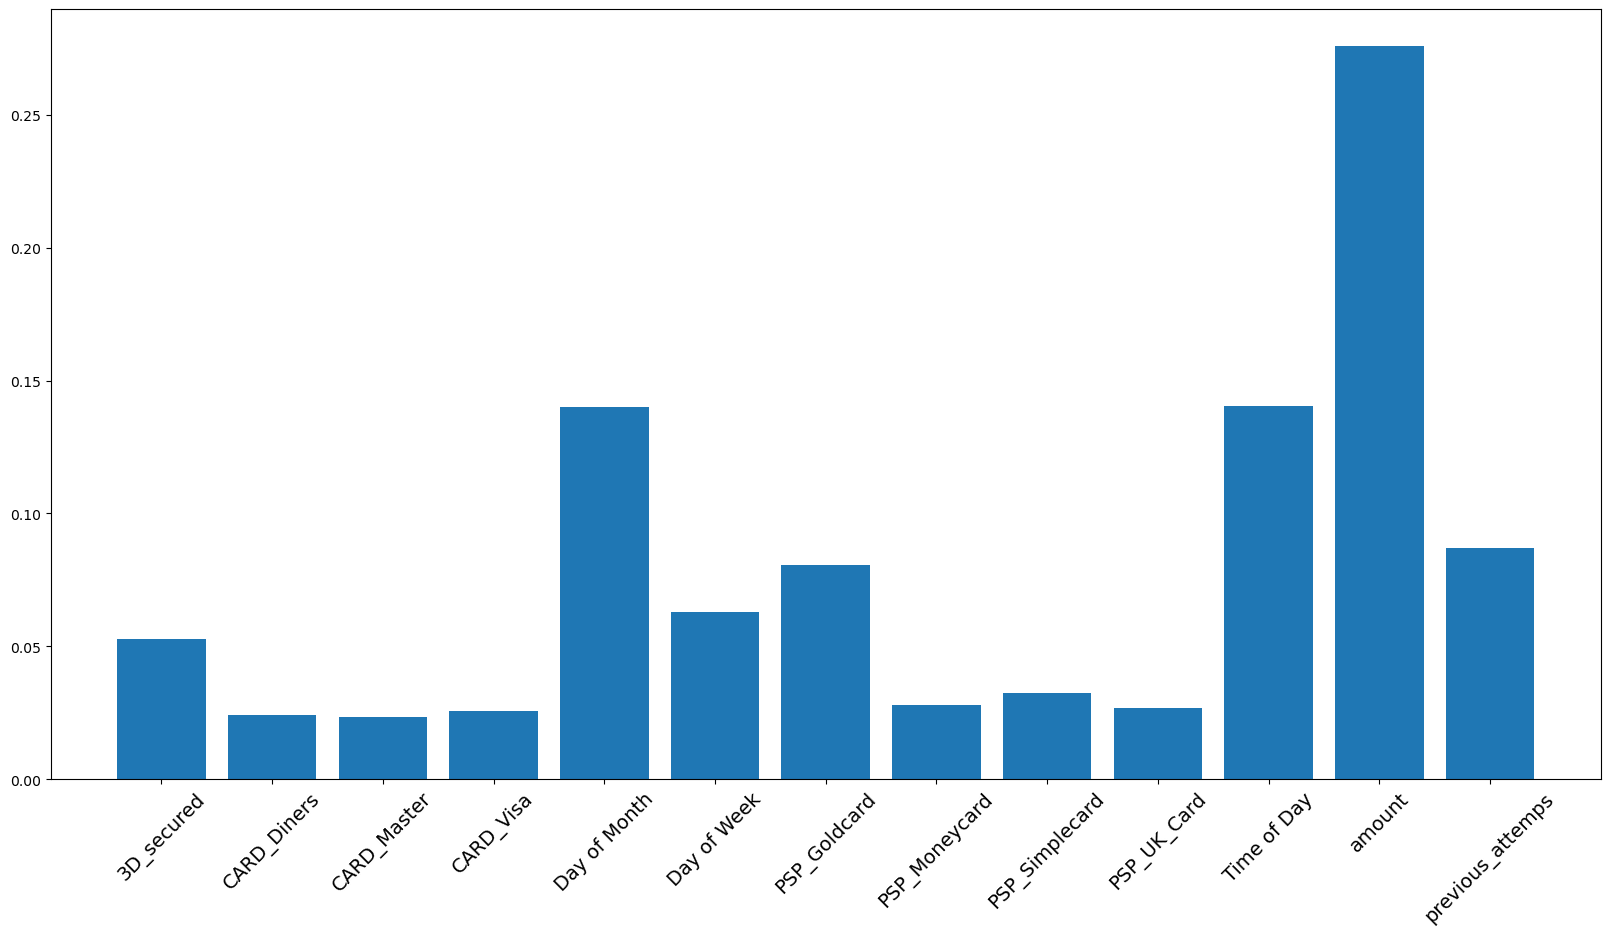

In [54]:
# Get feature importances
importances = best_random_forest.feature_importances_
# Plot feature importances
plt.figure(figsize=(20, 10))
plt.bar(range(X.shape[1]), importances, align="center")
plt.xticks(range(X.shape[1]), X_train.columns, rotation=45, fontsize=14)
plt.xlim([-1, X.shape[1]])
plt.savefig("../Visualisierungen/Feature_Importance.png", bbox_inches="tight")
plt.show()